In [22]:
! pip install torchtext
! python -m spacy download en --quiet

⚠ As of spaCy v3.0, shortcuts like 'en' are deprecated. Please use the
full pipeline package name 'en_core_web_sm' instead.
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Libraries

In [23]:
import re
import tqdm
import spacy
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torchtext
import numpy as np
import pandas as pd
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from torchtext.legacy.data import Field, BucketIterator,TabularDataset
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import nltk
from nltk.corpus import stopwords


In [24]:
STOPWORDS=stopwords.words('english')

# Parsing new dataset

In [25]:
def handle_apos(text):
    text = re.sub("'re", " are", text)
#     text = re.sub("'s", " is", text)
    text = re.sub("'m", " am", text)
    text = re.sub("'ll", " will", text)
    text = re.sub("'ve", " have", text)
    text = re.sub("'d", " would", text)
    text = re.sub("'t", " not", text)
    return text

def handle_punctuation(text):
    text = text.replace(".", " ")
    text = text.replace(",", " ")
    text = text.replace("!", " ")
    text = text.replace("?", " ")
    text = text.replace(";", " ")
    text = text.replace(":", " ")
    text = text.replace("-", " ")
    text = text.replace("(", " ")
    text = text.replace(")", " ")
    text = text.replace("[", " ")
    text = text.replace("]", " ")
    text = text.replace("{", " ")
    text = text.replace("}", " ")
    text = text.replace("/", " ")
    text = text.replace("\\", " ")
    text = text.replace("*", " ")
    text = text.replace("+", " ")
    text = text.replace("=", " ")
    text = text.replace("#", " ")
    text = text.replace("%", " ")
    text = text.replace("$", " ")
    text = text.replace("@", " ")
    text = text.replace("&", " ")
    text = text.replace("^", " ")
    text = text.replace("|", " ")
    text = text.replace("~", " ")
    text = text.replace("`", " ")
    text = text.replace("'", "")
    text = text.replace("\"", " ")
    text = text.replace("<", " ")
    text = text.replace(">", " ")
    text = text.replace("  ", " ")
    return text

In [26]:
def stop_words(text):
    text=text.split()
    re=[]
    for x in text:
        if x not in STOPWORDS:
            re.append(x)
    return " ".join(re)

In [27]:
import csv
csvreader=csv.reader(open("../input/domaintermextraction/raw_data.csv"))
header = []
header = next(csvreader)
header
dataset = []
label = []
# arr=[16,16,16,16,16]
for row in csvreader:
    row=" ".join(row).split("\t")
    val=re.sub(' +', ' ', handle_punctuation(handle_apos(row[0].lower())))
    dataset.append(re.sub(' +', ' ', stop_words(re.sub(r"[^a-zA-Z]+", " ", handle_punctuation(handle_apos(" ".join(row[3:]).lower()))))))  
    label.append(val)
   
  
train=pd.DataFrame({'content':dataset,'category':label})
train.to_csv("data_sw.csv",index=False)

# Dataloaders

In [28]:
english=spacy.load('en_core_web_sm')

In [29]:
def en_tokenizer(text):
    tt = [token.text for token in english.tokenizer(text)]
    new_tt = []
    for i in range(len(tt)-1):
        new_tt.append(" ".join(tt[i:i+2]))
#     print(new_tt)
    return new_tt

def lb_tokenizer(text):
    return  [token.text for token in english.tokenizer(text)]


en_field = Field(tokenize=en_tokenizer,lower=True)
lb_field = Field(tokenize=lb_tokenizer,lower=True)

In [30]:
train_data=TabularDataset.splits(path="../input/domaintermextraction",train="data_sw.csv",format="csv",fields=[('content',en_field),('category',lb_field)],skip_header=True)[0]

In [31]:
batch_size=16
en_field.build_vocab(train_data,min_freq=2)
lb_field.build_vocab(train_data,specials_first=False)

In [32]:
len(en_field.vocab.itos)

69373

In [33]:
import pickle 
output_dict=pickle.load(open("../input/domaintermextraction/pandora.pkl","rb"))
unk_vect=output_dict["en_field"].vocab.vectors[output_dict["en_field"].vocab.stoi["<unk>"]]

In [34]:
glove_emmbed_dict = {}
glove_emmbed_dict["<unk>"]=unk_vect
glove_emmbed_dict["<pad>"]=np.zeros((200),dtype=float)

with open('../input/glove6b/glove.6B.200d.txt','r') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:],'float32')
        glove_emmbed_dict[word]=vector

400000it [00:22, 18052.03it/s]


In [35]:
def get_val(dic,val):
    if val in dic:
        return dic[val]
    else:
        return dic["<unk>"]

def n_gram(dic,embedd):
    re=[]
    for x in dic:
        x=x.split()
        temp=np.zeros((200),dtype=float)
        for y in x:
            temp+=np.array(get_val(embedd,y))
        re.append(temp/len(x))
    return np.array(re)

In [36]:
en_field.vocab.vectors=n_gram(en_field.vocab.stoi,glove_emmbed_dict)

In [37]:
en_field.vocab.vectors.shape

(69373, 200)

In [38]:
len(en_field.vocab.itos)

69373

In [39]:
train_iter,_,_ = BucketIterator.splits((train_data,train_data,train_data), batch_size = batch_size,sort_within_batch=True,sort_key=lambda x: len(x.content),device = device)

## save variables

In [43]:
del  header,dataset,value,csvreader

In [44]:
en_field.vocab.vectors

array([[ 0.05530979,  0.00204107,  0.00948162, ...,  0.08513141,
         0.01224773, -0.00181833],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.230075  ,  0.170513  , -0.74910998, ..., -0.0208515 ,
         0.10897   , -0.078408  ],
       ...,
       [ 0.30008501,  0.026372  , -0.104404  , ...,  0.07012   ,
        -0.0864795 ,  0.02845499],
       [ 0.31545049,  0.110261  , -0.1102165 , ...,  0.42428   ,
         0.61940499,  0.21938699],
       [ 0.45667998,  0.108215  , -0.0713045 , ..., -0.11021999,
        -0.06906   ,  0.332875  ]])

In [45]:
! mkdir ./bi_gram

In [46]:
import pickle
output_dict={}
output_dict["en_field"]=en_field
output_dict["lb_field"]=lb_field
output_dict["embedding"]=en_field.vocab.vectors
pickle.dump(output_dict,open("./bi_gram/pandora_bi.pkl","wb"))

# Architecture

In [47]:
class LSTM_attention(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim_1, batch_size):
        super().__init__()
        self.weight = nn.Parameter(torch.zeros((batch_size,2*hidden_dim_1, 1)), requires_grad = True)
        self.embedding_layer = nn.Embedding(vocab_size, embedding_dim)
        self.embedding_layer.weight.data.copy_(torch.tensor(en_field.vocab.vectors))
        self.embedding_layer.weight.requires_grad = False ## freeze embeddings
        self.lstm_layer = nn.LSTM(input_size=embedding_dim, hidden_size=hidden_dim_1, num_layers=5, batch_first=True, bidirectional=True)
        self.fc_layer1 = nn.Linear(2*hidden_dim_1, 5)    
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, input_sent):
        input_emb = self.embedding_layer(input_sent)
        sent_lstm_out,hid = self.lstm_layer(input_emb)
        M = torch.tanh(sent_lstm_out)
        mul = torch.matmul(M, self.weight)
        alpha = self.softmax(mul)
        r = torch.matmul(torch.transpose(sent_lstm_out, 1, 2), alpha)
        output = self.fc_layer1(r.reshape((r.shape[0], r.shape[1])))
        return output, alpha

In [48]:
lstm_model = LSTM_attention(en_field.vocab.vectors.shape[0], en_field.vocab.vectors.shape[1], 300, batch_size).double().cuda()
optimizer = optim.SGD(lstm_model.parameters(), lr=0.1)
loss_function = nn.CrossEntropyLoss()
num_epochs = 150
a = []
best_loss=float("inf")
best_accuracy=0
state={}
acc_arr=[]
loss_arr=[]
for epoch in range(num_epochs):
    current_loss = 0
    accuracy=0
    count=0
    for x in tqdm(train_iter):
        if x.content.T.shape[0] == 16:
            x_input = x.content.T.cuda()
            out, alpha = lstm_model(x_input)
            y_label =  x.category.T.reshape(x.category.T.shape[0]).cuda()
            accuracy_dash=accuracy_score(list(np.argmax(out.cpu().data.numpy(),axis=1)),list(y_label.cpu().data.numpy()))
            accuracy+=accuracy_dash
            count+=1
            loss = loss_function(out,y_label)
            current_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
    accuracy=accuracy/count
    current_loss=current_loss/count
    acc_arr.append(accuracy)
    loss_arr.append(current_loss)
    print("Epoch : ",epoch)
    print("Accuracy : ",accuracy)
    print("Loss : ",current_loss)
    if(best_accuracy<accuracy or accuracy>0.999):
        if accuracy - best_accuracy > 0.03 or accuracy > 0.95:
            torch.save(lstm_model,"./bi_gram/model_"+str(epoch)+"_"+str(accuracy)+"_"+str(current_loss)+".pt")
        best_accuracy=accuracy

  4%|▍         | 4/102 [00:04<01:53,  1.16s/it]


KeyboardInterrupt: 

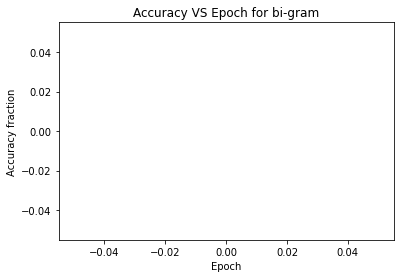

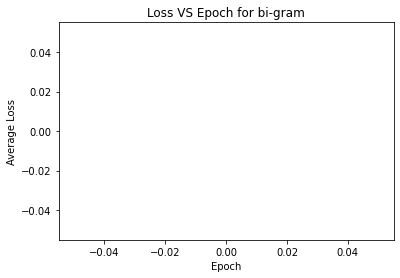

In [49]:
import matplotlib.pyplot as plt
plt.plot(acc_arr)
plt.title("Accuracy VS Epoch for bi-gram")
plt.xlabel("Epoch")
plt.ylabel("Accuracy fraction")
plt.show()
plt.plot(loss_arr)
plt.title("Loss VS Epoch for bi-gram")
plt.ylabel("Average Loss")
plt.xlabel("Epoch")
plt.show()

In [50]:
torch.save(lstm_model,"./bi_gram/final_model")

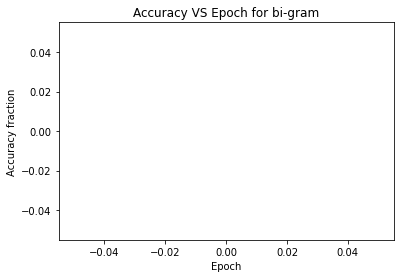

In [51]:
import matplotlib.pyplot as plt
plt.plot(acc_arr)
plt.title("Accuracy VS Epoch for bi-gram")
plt.xlabel("Epoch")
plt.ylabel("Accuracy fraction")
plt.savefig('./bi_gram/acc.jpg')

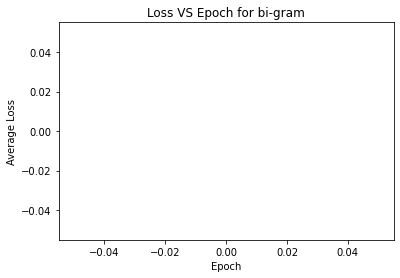

In [52]:
plt.plot(loss_arr)
plt.title("Loss VS Epoch for bi-gram")
plt.xlabel("Epoch")
plt.ylabel("Average Loss")
plt.savefig('./bi_gram/loss.jpg')

In [53]:
import shutil
shutil.make_archive("bigram", 'zip', "./bi_gram")

'/kaggle/working/bigram.zip'

In [54]:
import os
os.chdir(r'/kaggle/working/')
from IPython.display import FileLink
FileLink(r'./bigram.zip')

/kaggle/working/bigram.zip

In [55]:
key_word_scores = {}
r = 50
lstm_model.eval()
with torch.no_grad():
    for x in tqdm(train_iter):
        if x.content.T.shape[0] == 16:
            x_t = x.content.T
            label = np.array(x.category.T.cpu())
            label = label.reshape((label.shape[0]))
            out, alpha = lstm_model(x_t)
            alpha = alpha.cpu()
            for j in range(alpha.shape[0]):
                scores = []
                words = []
                ind = 0
                for k in range(alpha.shape[1]):
                    scores.append([alpha[j][k], en_field.vocab.itos[int(x_t[j][k])]])
                scores.sort(key=lambda y:y[0], reverse=True)
                while ind < alpha.shape[1]:
                    k = scores[ind]
                    if k[1] != "<pad>" and k[1] != "<unk>" and k[1] != " ":
                        words.append([k[1], k[0]])
                    ind += 1
                    if len(words) == r:
                        break
                if lb_field.vocab.itos[label[j]] not in key_word_scores.keys():
                    key_word_scores[lb_field.vocab.itos[label[j]]] = []
                key_word_scores[lb_field.vocab.itos[label[j]]].append(words)

 11%|█         | 11/102 [00:04<00:34,  2.60it/s]


KeyboardInterrupt: 

In [56]:
pickle.dump(key_word_scores, open("bigram_keywords.pkl","wb"))